In [1]:
import os, sys

import numpy as np
import pandas as pd
import time, random, math
import copy, gc
from collections import deque
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
import torch
from torch.optim import Adam
from torch.distributions import Categorical

In [2]:
from method_1 import SearchAvailablePosition
from method_2 import SearchAction
from method_3 import ChangeBoard

from Othello import Othello

In [3]:
from RL.train_model import test, get_play_data, randomAgent, greedyAgent
#from RL.model import Model, basis_conv2d
from RL.optimize_model import optimize_a2cmodel as optimize_model
from RL.A2C_agent import agent as a2c_agent
from RL.DQN_agent import agent as dqn_agent
from RL.Replay_Memory import Replay_Memory
from RL.noise import AdaptiveParamNoiseSpec

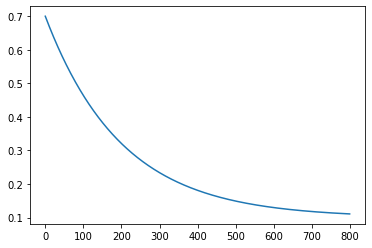

In [4]:
x = np.arange(0,800,1)
eps_decay=200
plt.plot(0.1 + (0.7 - 0.1) *  np.exp(-1. * x / eps_decay))

In [5]:
win_1 = []
win_2 = []
l=[]
noise = AdaptiveParamNoiseSpec(initial_stddev=0.5)
dqn_1 = dqn_agent(input_dim=3, lam=0.8, gamma=.95, lr=1e-4, noise=noise, eps_decay=200)
#param = torch.load('dqn_param2.pt')
#dqn_1.policy_model.load_state_dict(param)
#dqn_2 = dqn_agent(input_dim=3, lam=0.6, gamma=.9, lr=1e-4)
random_agent = randomAgent()
greedy_agent = greedyAgent()
memory = Replay_Memory(100)

In [31]:
for i in tqdm(range(200)):
    if i%8==0:
        dqn_2 = copy.deepcopy(dqn_1)
    for _ in range(1):
        tmp_w_1 = 0
        tmp_w_2 = 0
        
        agent_2 = np.random.choice([dqn_2, greedy_agent, random_agent], p=[0.5,0.25,0.25])
        data_1, data_2 = get_play_data(dqn_1 , agent_2)
        
        #data_1, data_2 = get_play_data(dqn_1, dqn_2)
        
        memory.push(data_1)
        memory.push(data_2)
        tmp_w_1+=float(data_1['rewards'][0])
        tmp_w_2+=float(data_2['rewards'][0])
        
        data_2, data_1 = get_play_data(dqn_2 , dqn_1)
        memory.push(data_1)
        memory.push(data_2)
        tmp_w_1+=float(data_1['rewards'][0])
        tmp_w_2+=float(data_2['rewards'][0])
        gc.collect()
        
        
    win_1.append(tmp_w_1)    
    win_2.append(tmp_w_2)    
    dqn_1.optimize_model_withNoise(memory)

c:\users\abcdm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [32]:
#torch.save(dqn_1.policy_model.state_dict(), 'dqn_param2.pt')

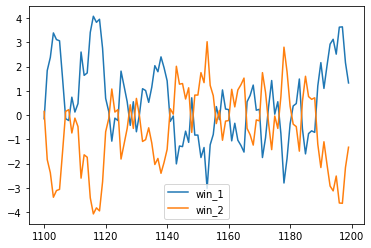

In [33]:
win_1_df = pd.DataFrame(win_1).rolling(5,min_periods=1).mean()
plt.plot(win_1_df[-100:], label='win_1')
win_2_df = pd.DataFrame(win_2).rolling(5,min_periods=1).mean()
plt.plot(win_2_df[-100:], label='win_2')
plt.legend()
plt.show()

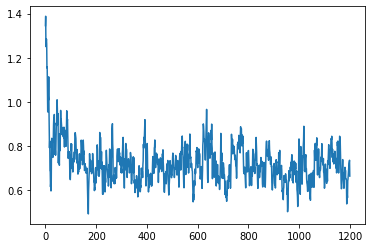

In [34]:
loss_df = pd.DataFrame(dqn_1.loss_1_list).rolling(5,min_periods=1).mean()
plt.plot(loss_df)
plt.show()

In [35]:
s = torch.cat([transaction['states'] for transaction in list(memory.memory)[1:2]], dim=0)
out = dqn_1.policy_model(s)
policy = out["policy"]

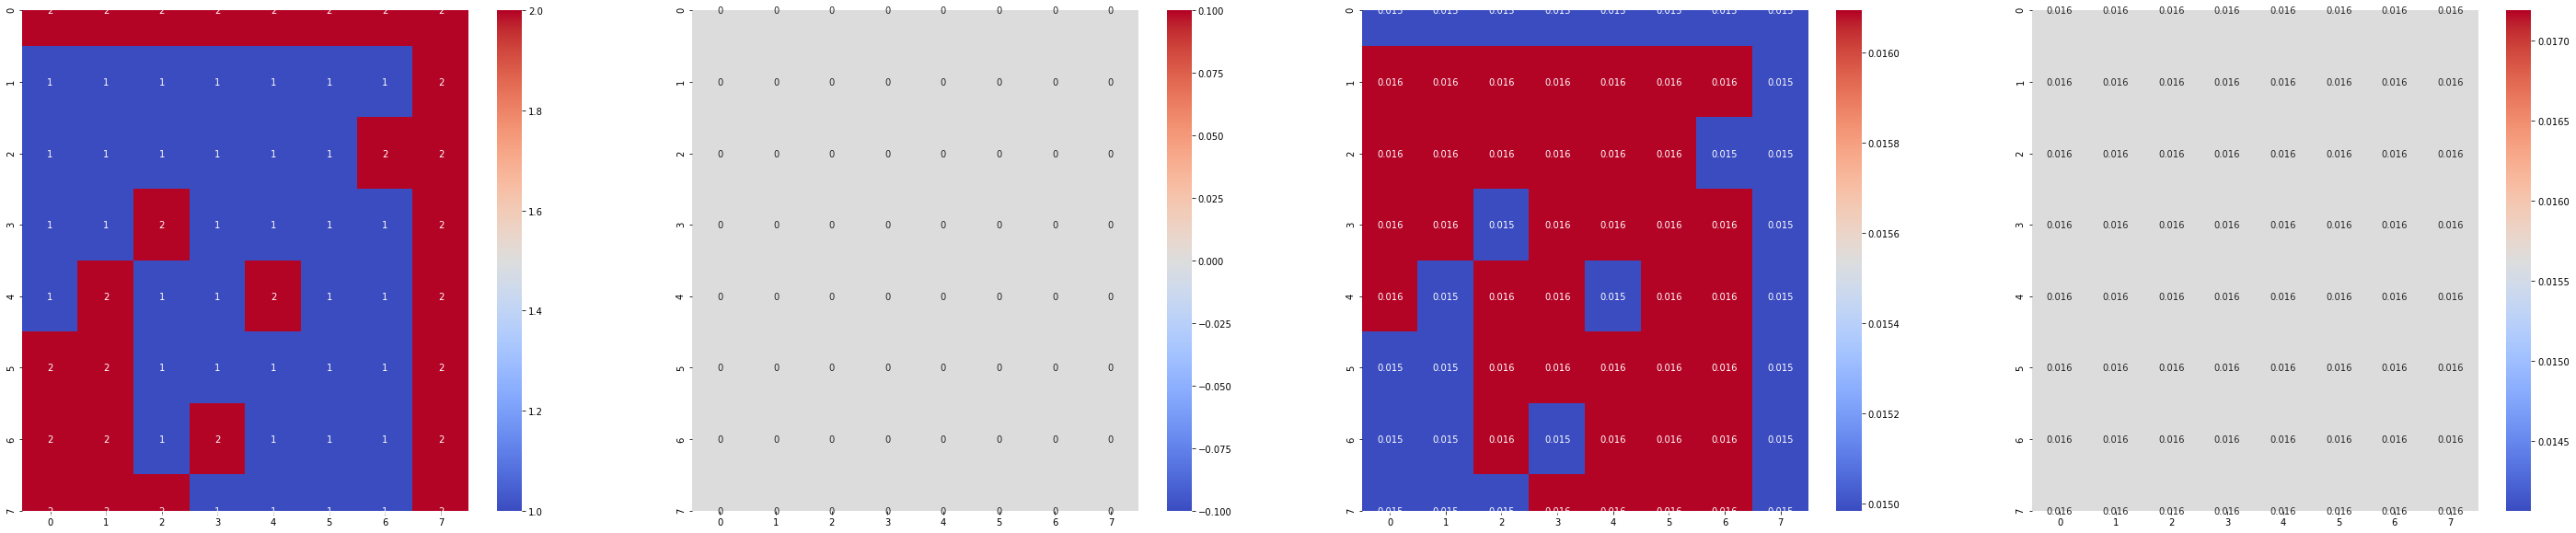

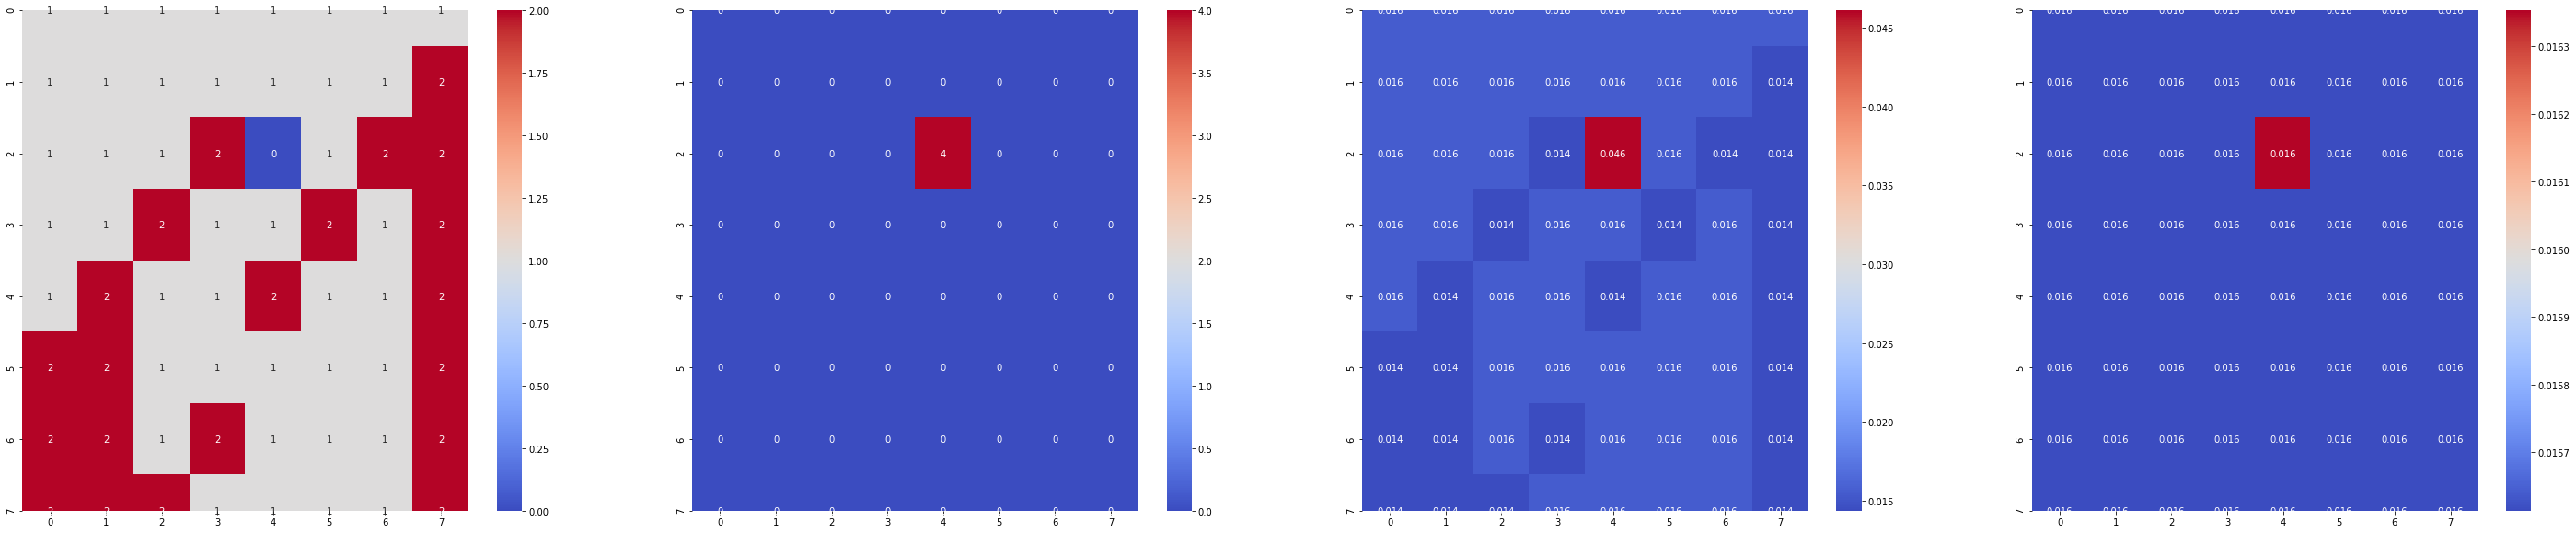

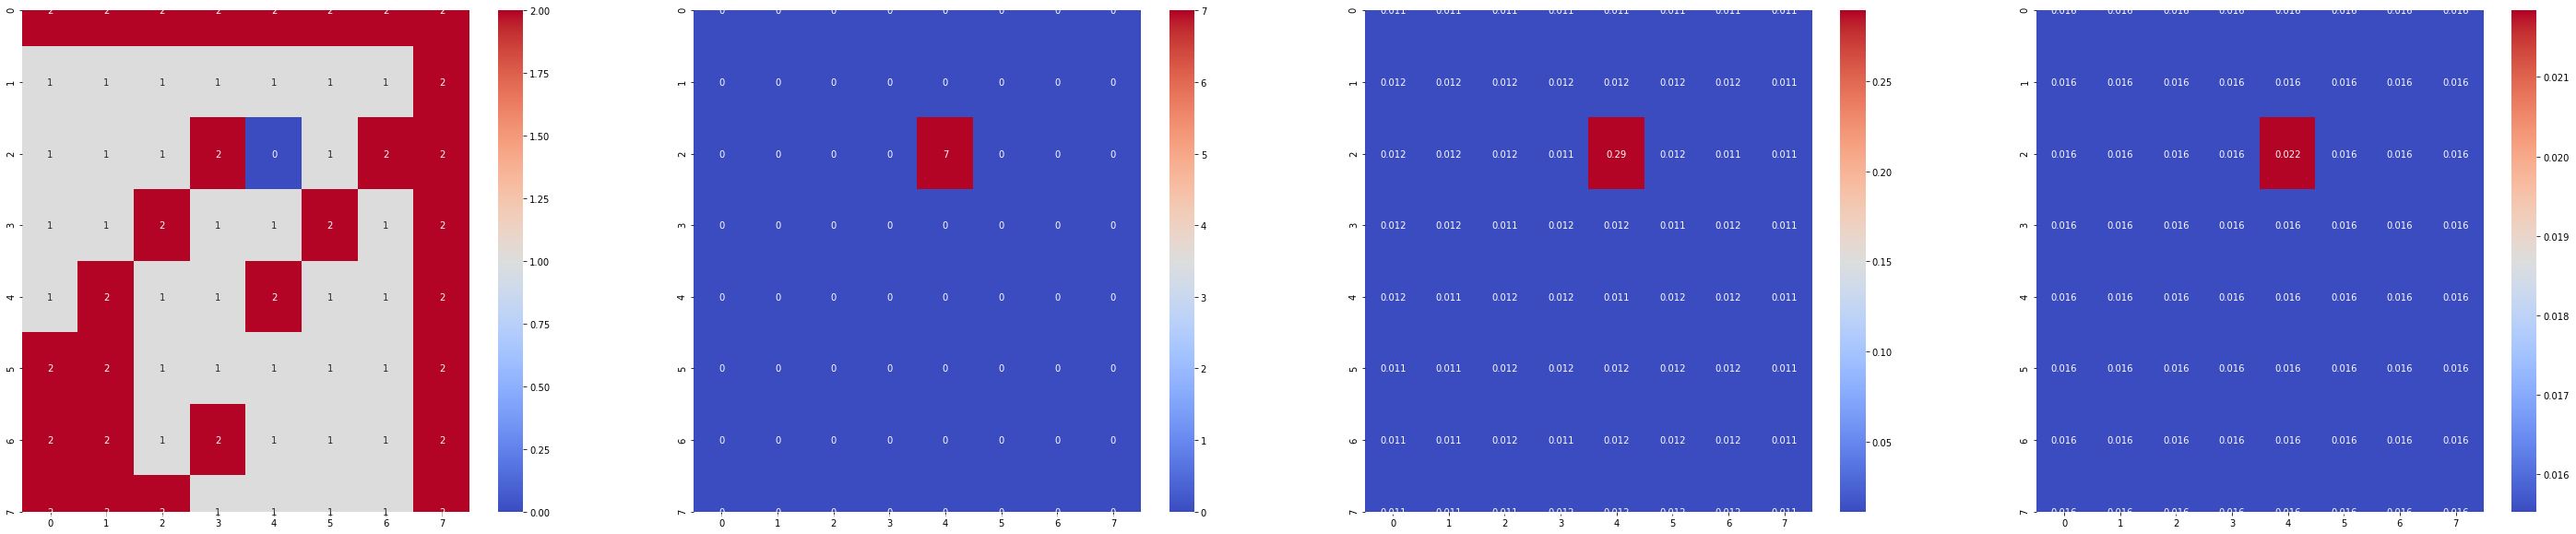

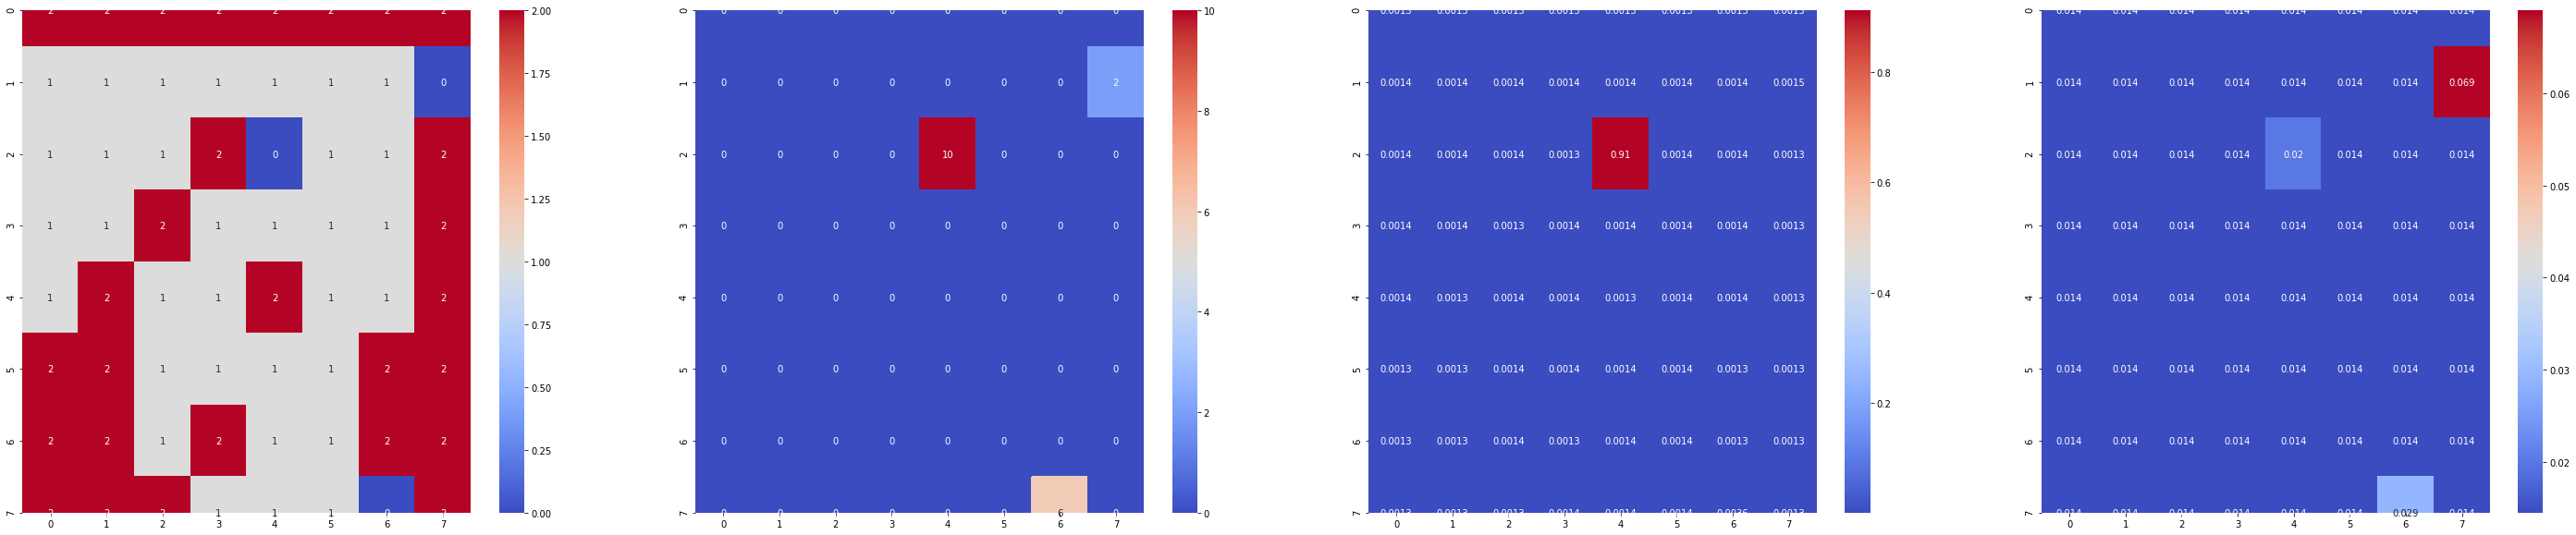

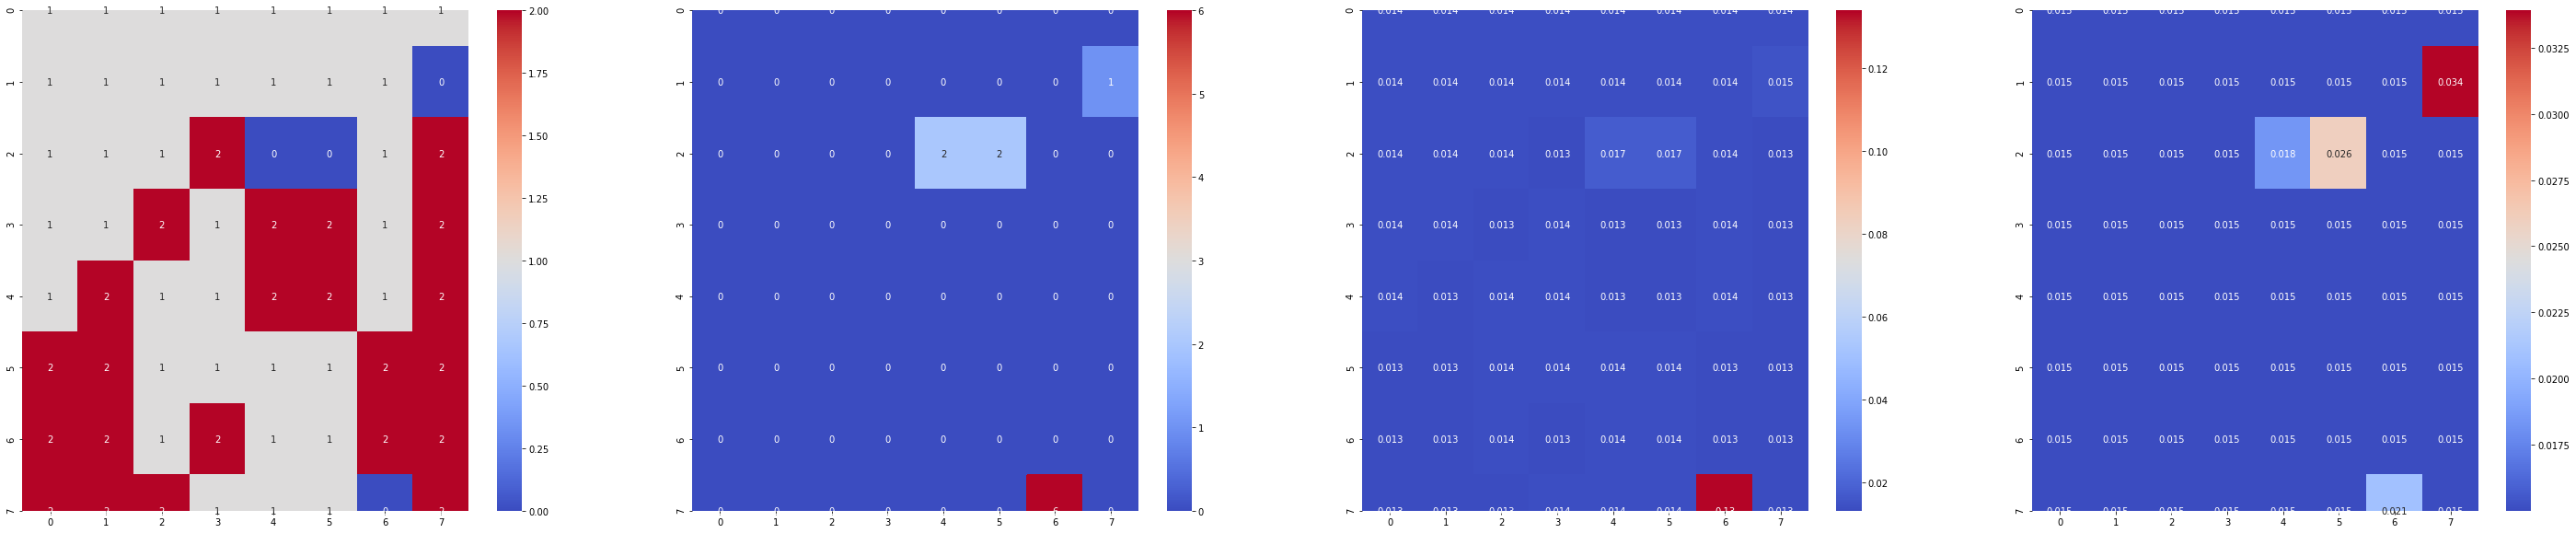

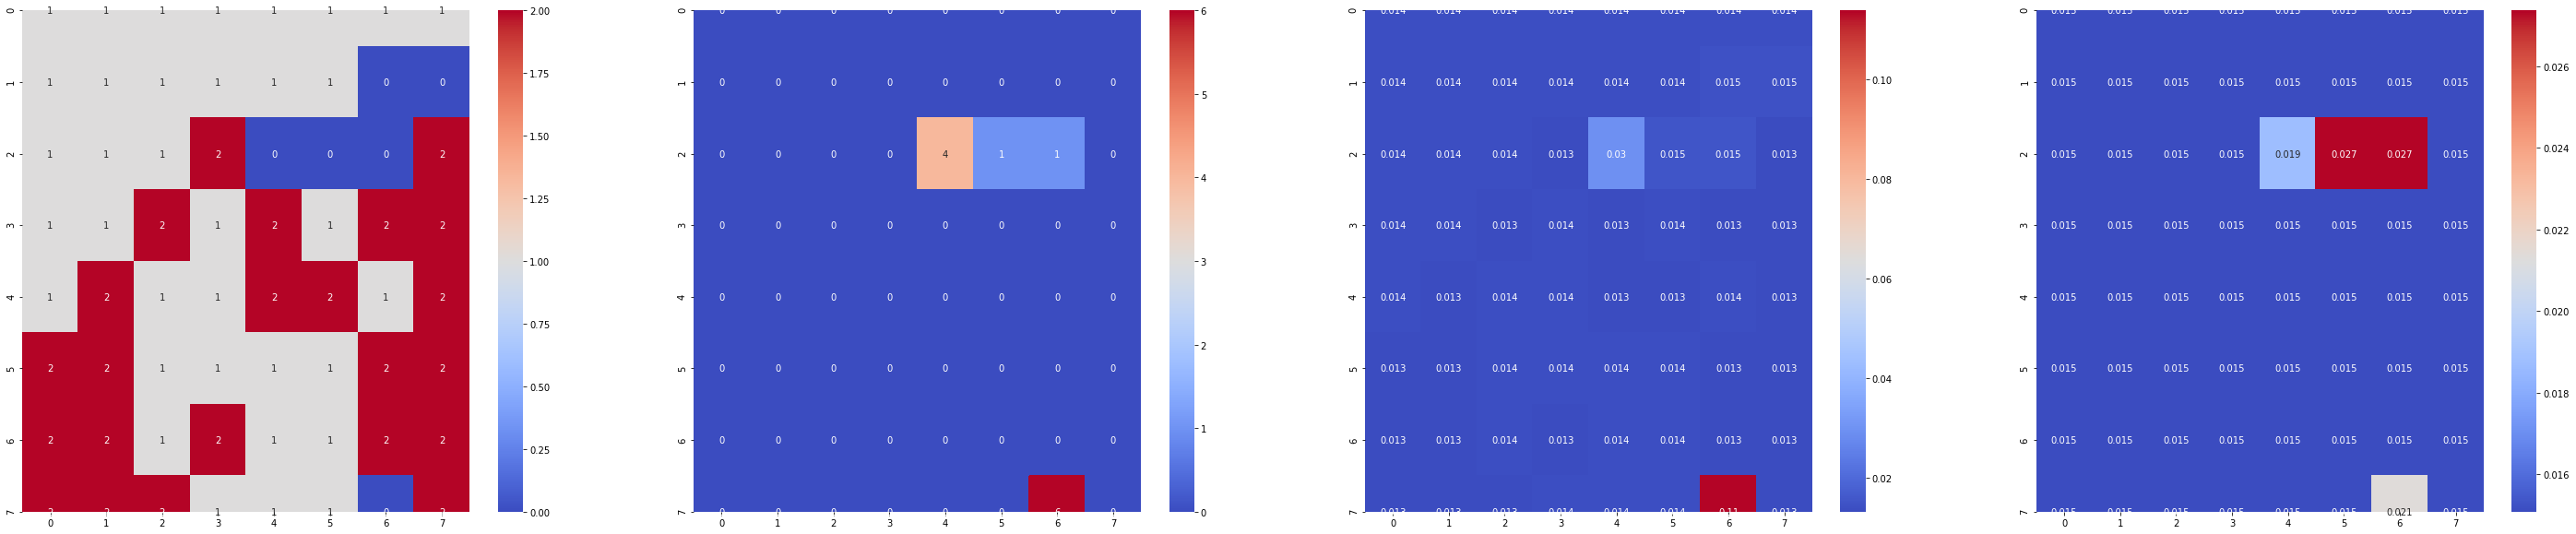

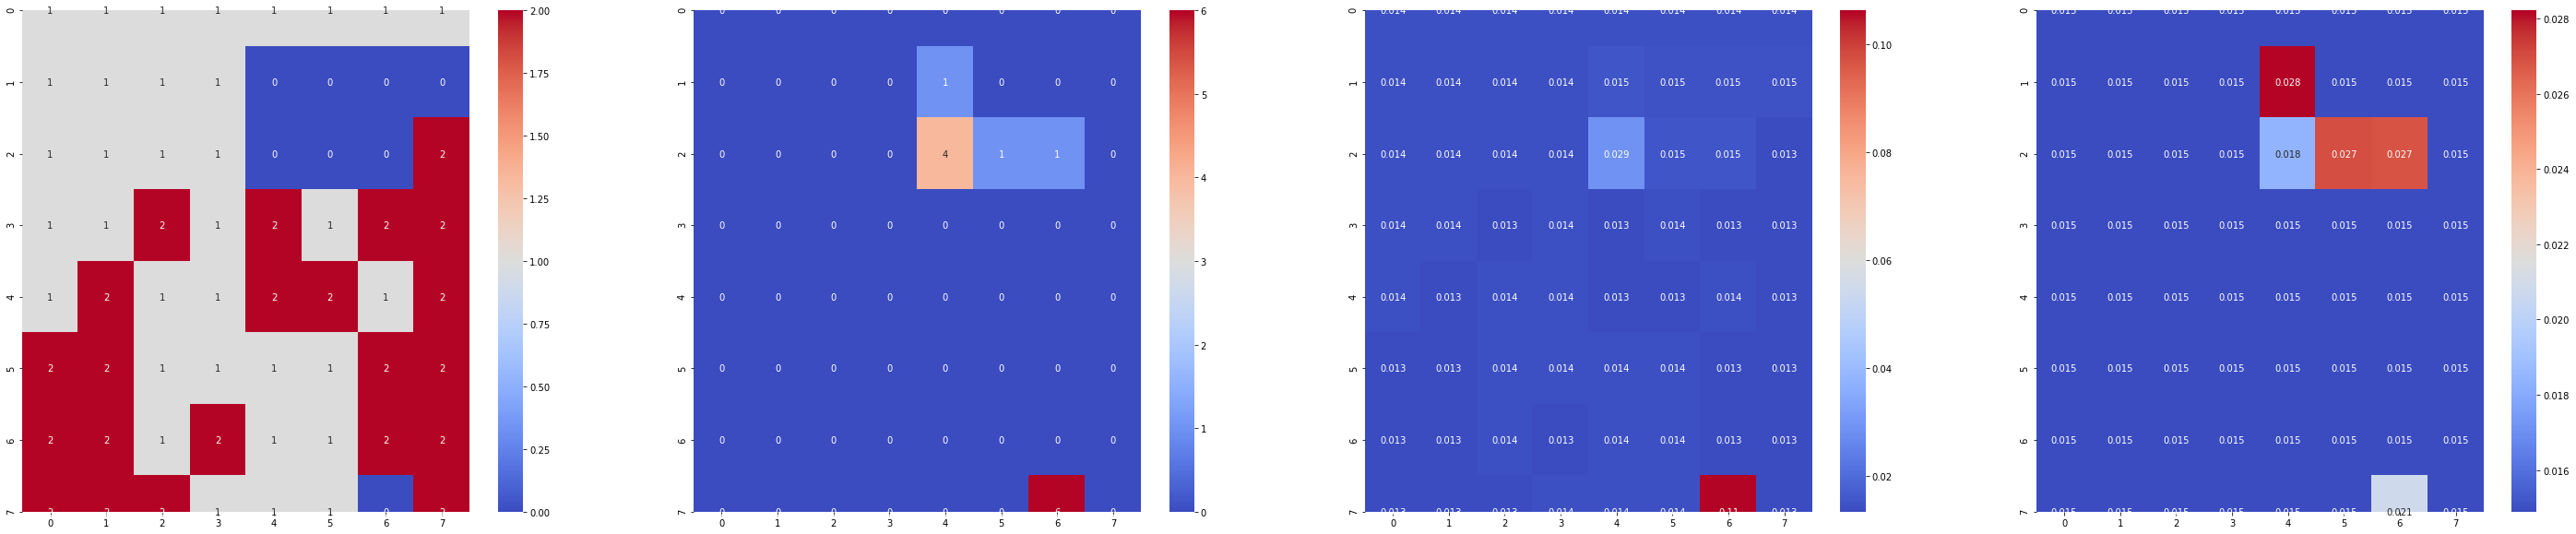

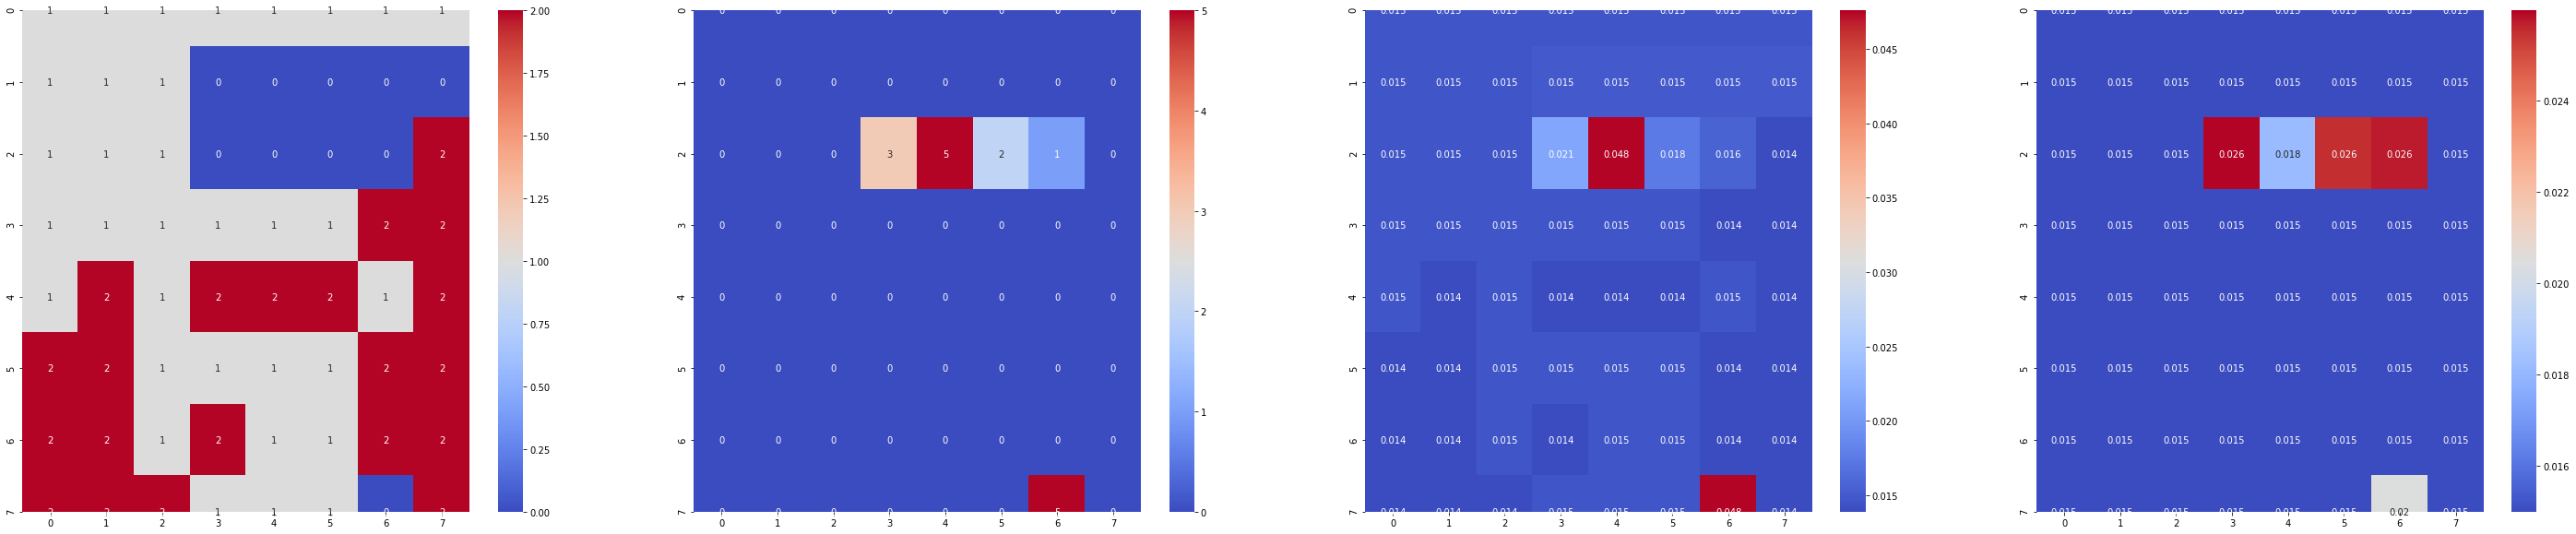

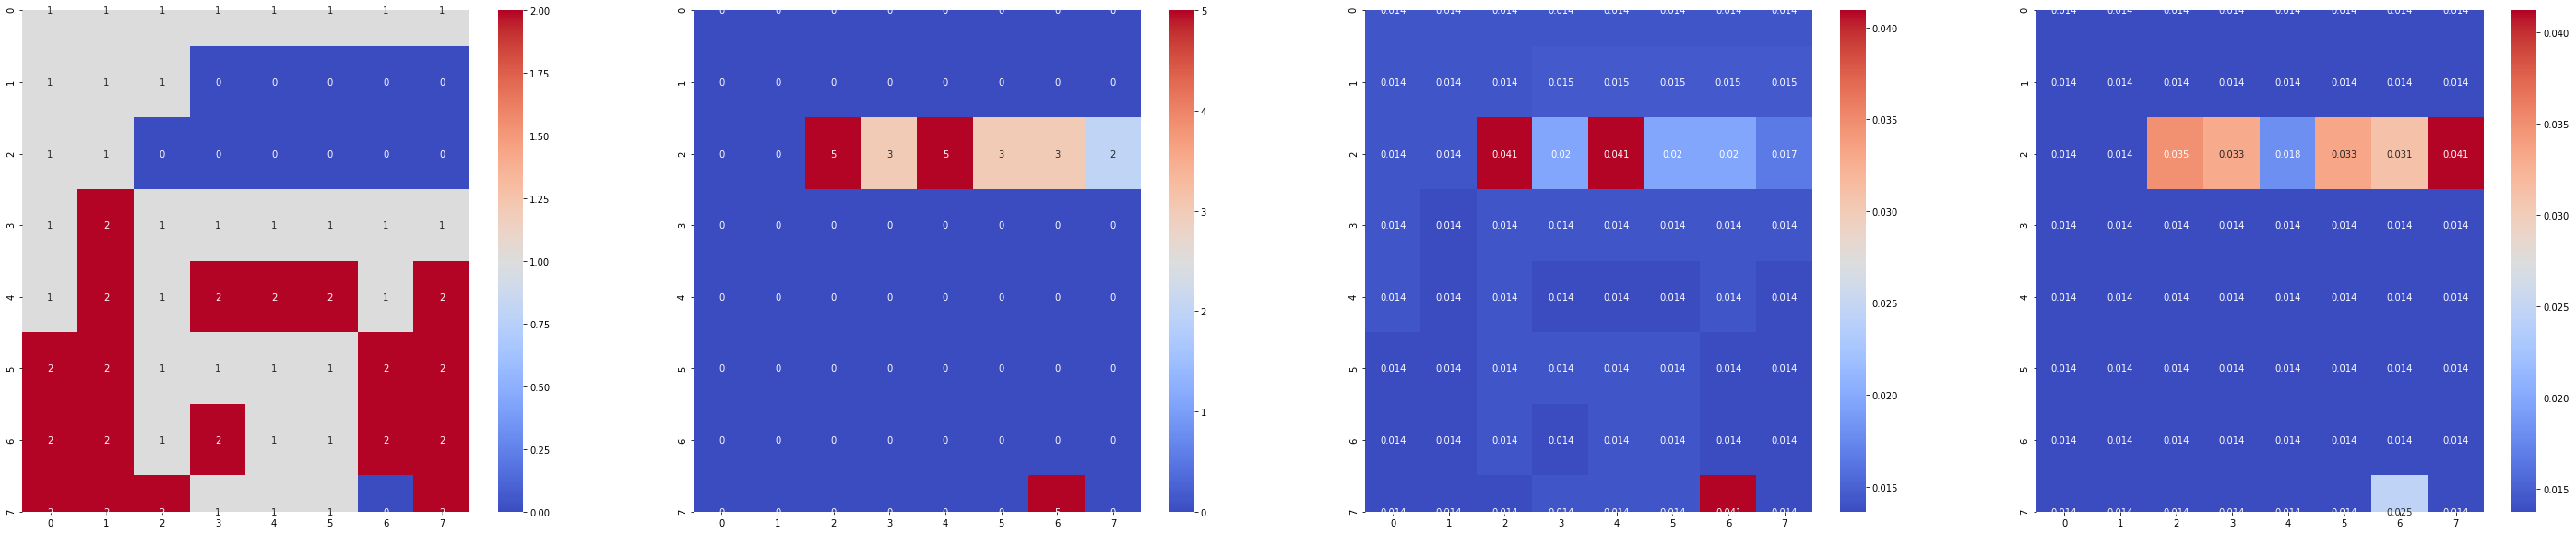

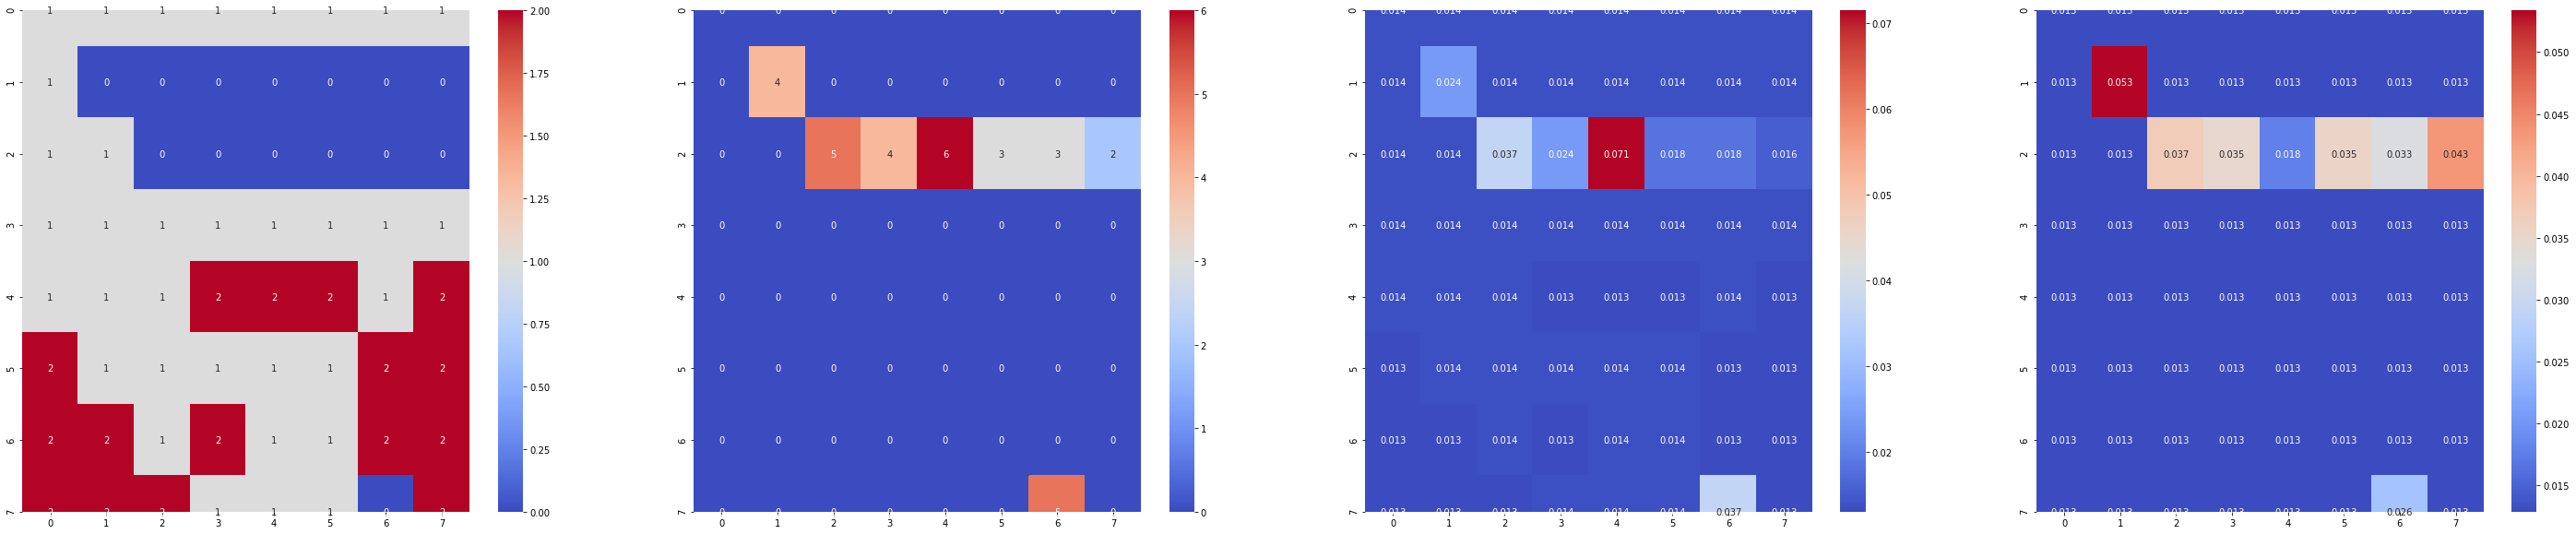

In [36]:
for idx in range(10):
    plt.figure(figsize=(50,10))
    plt.subplot(1,4,1)
    x = s[idx][0]+2*s[idx][1]
    sns.heatmap((x).detach().numpy().astype(int), annot=True, cmap='coolwarm')

    plt.subplot(1,4,2)
    sns.heatmap((s[idx][2]).detach().numpy().astype(int), annot=True, cmap='coolwarm')

    plt.subplot(1,4,3)
    #一番ひっくり返エセル箇所が大きいところのattention をみる
    #show_postion = s[idx][2].flatten().detach().numpy().argsort()[-1]
    #a = out['attention'][idx][show_postion].reshape(8,8).detach().numpy()
    
    #attention の合計をみてみる
    a = (nn.Softmax(0)(sum([v for v in out['attention'][idx]]))).reshape(8,8).detach().numpy()
    
    sns.heatmap(a, cmap='coolwarm', annot=True)

    plt.subplot(1,4,4)
    p=nn.Softmax(0)(policy[idx]).reshape(8,8).detach().numpy()
    sns.heatmap(p, annot=True, cmap='coolwarm')
    
    plt.show()

In [37]:
#!pip install -U seaborn

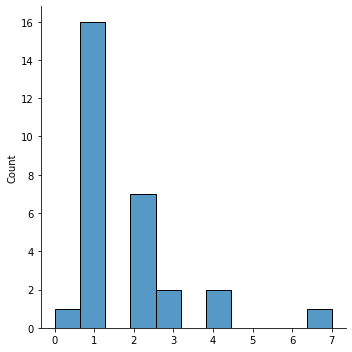

In [38]:
sns.displot(s[:,2,:,:].flatten(1).gather(1, policy.argsort(1))[:,-1].detach().numpy().flatten())
plt.show()

In [39]:
othello = Othello()
random_agent = randomAgent()
greedy_agent = greedyAgent()
w_1=0
w_2=0
draw=0

In [40]:
for _ in tqdm(range(400)):
    board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.make()
    while not done:
        if othello.color==1:
            setrow, setcol = dqn_1.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        else:
            agent_tmp = random.choice([greedy_agent, random_agent])
            setrow, setcol = agent_tmp.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
        if done:
            if len(board[board==1])>len(board[board==2]):
                w_1+=1
            elif len(board[board==1])<len(board[board==2]):
                w_2+=1
            else:
                draw+=1

c:\users\abcdm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [41]:
print(w_1,w_2,draw)

297 97 6


In [42]:
othello = Othello()

w_1=0
w_2=0
draw=0

In [43]:
for _ in tqdm(range(400)):
    board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.make()
    while not done:
        if othello.color==1:
            agent_tmp = random.choice([greedy_agent, random_agent])
            setrow, setcol = agent_tmp.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        else:
            setrow, setcol = dqn_1.take_action(board, changeable_Pos, Position_Row, Position_Col, Change_Position)
        board, changeable_Pos, Position_Row, Position_Col, Change_Position, done = othello.step(setrow, setcol)
        if done:
            if len(board[board==1])>len(board[board==2]):
                w_1+=1
            elif len(board[board==1])<len(board[board==2]):
                w_2+=1
            else:
                draw+=1

c:\users\abcdm\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [44]:
print(w_1,w_2,draw)

96 288 16
